In [ ]:
### Install Required Libraries
!pip install pandas numpy scikit-learn spacy matplotlib seaborn wordcloud nltk xgboost torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset



In [ ]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm')



In [3]:
### Load and Preprocess Data
labeled_df = pd.read_csv("/content/Labeled dataset.csv")  # Change to actual dataset path
# Encode labels into numerical format
label_mapping = {'CG': 0, 'OR': 1}  # Adjust according to your dataset
labeled_df['label'] = labeled_df['label'].map(label_mapping)

# Check if there are any unmapped values
print("Unique labels after mapping:", labeled_df['label'].unique())

# Display dataset info
labeled_df.head()




Unique labels after mapping: [0 1]


,category,rating,label,review
0,Home_and_Kitchen_5,5,0,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,0,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,0,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,0,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,0,Very nice set. Good quality. We have had the s...


In [4]:
# Data Cleaning Function
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters
    text = text.lower()
    text = ' '.join([token.lemma_ for token in nlp(text)])  # Lemmatization
    return text

labeled_df['cleaned_text'] = labeled_df['review'].apply(clean_text)



In [5]:
# Add Behavioral Features
from textblob import TextBlob
labeled_df['review_length'] = labeled_df['cleaned_text'].apply(lambda x: len(x.split()))
labeled_df['sentiment_score'] = labeled_df['cleaned_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

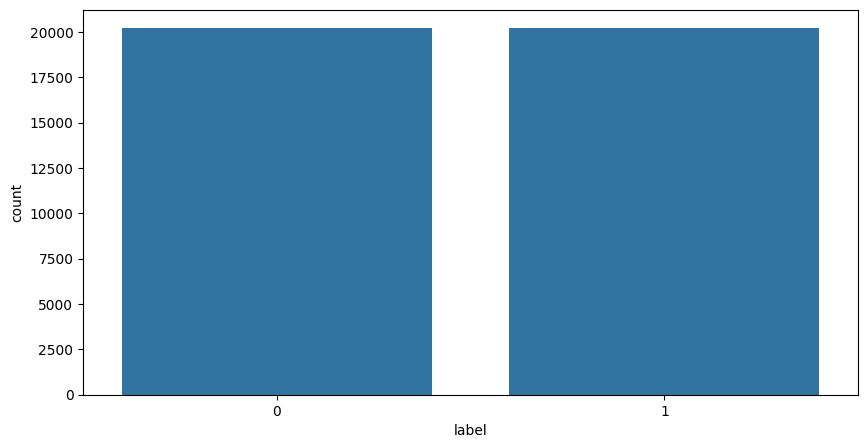

In [6]:
###  EDA - Data Visualization
plt.figure(figsize=(10,5))
sns.countplot(x=labeled_df['label'])  # Fake vs Real distribution
plt.show()




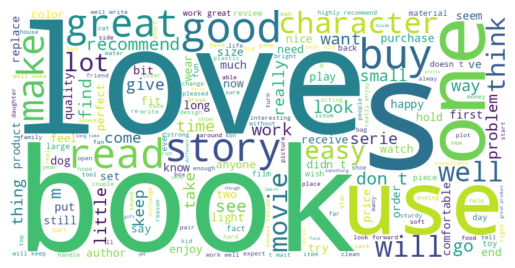

In [7]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(labeled_df['cleaned_text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
### Feature Engineering - TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=3000)  # Reduced features for faster processing
X = tfidf.fit_transform(labeled_df['cleaned_text']).toarray()
y = labeled_df['label']



In [9]:
import joblib

# Save the trained TF-IDF vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
print("TF-IDF vectorizer saved successfully!")


TF-IDF vectorizer saved successfully!


In [10]:
### Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)  # Increased test size for faster training



In [11]:
from sklearn.model_selection import  GridSearchCV
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Naïve Bayes': MultinomialNB(),
    'XGBoost': XGBClassifier()
}
# Hyperparameter tuning for all models
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'Naïve Bayes': {'alpha': [0.1, 1, 10]}
}

best_models = {}

for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    gs = GridSearchCV(model, param_grids[model_name], cv=3)
    gs.fit(X_train, y_train)
    best_models[model_name] = gs.best_estimator_
    print(f"Best parameters for {model_name}: {gs.best_params_}")

# Train & Evaluate Models
for name, model in best_models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc*100:.2f}%")
    print(classification_report(y_test, y_pred))
    print("-"*50)


Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Tuning Random Forest...
Best parameters for Random Forest: {'max_depth': None, 'n_estimators': 200}
Tuning Naïve Bayes...
Best parameters for Naïve Bayes: {'alpha': 1}
Tuning XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 200}
Training Logistic Regression...
Evaluating Logistic Regression...
Logistic Regression: 88.70%
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     10149
           1       0.89      0.88      0.89     10067

    accuracy                           0.89     20216
   macro avg       0.89      0.89      0.89     20216
weighted avg       0.89      0.89      0.89     20216

--------------------------------------------------
Training Random Forest...
Evaluating Random Forest...
Random Forest: 87.09%
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     10149
   

In [12]:
### Deep Learning - BERT Model Preparation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("Unique values in labels before conversion:", labeled_df['label'].unique())
print("Any NaN values?", labeled_df['label'].isna().sum())

# Remove NaN values and force conversion to int
labeled_df = labeled_df.dropna(subset=['label'])  # Remove NaNs
labeled_df['label'] = labeled_df['label'].astype(int)  # Convert to integers

class ReviewDataset(Dataset):
    def __init__(self, texts, labels):
        assert all(isinstance(label, int) for label in labels), "Labels must be integers"
        self.texts = texts
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert to LongTensor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), self.labels[idx]

train_dataset = ReviewDataset(labeled_df['cleaned_text'].tolist(), labeled_df['label'].tolist())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(3):
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        labels = labels.long()  # Convert labels to LongTensor

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Unique values in labels before conversion: [0 1]
Any NaN values? 0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.0187
Epoch 2, Loss: 0.0051
Epoch 3, Loss: 0.0204


In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Switch model to evaluation mode
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in train_loader:  # Use train_loader instead of test_loader
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = outputs.logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy and classification report
accuracy = accuracy_score(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=['CG', 'OR'])  # Adjust labels if needed

print(f"BERT Model Accuracy on Training Data: {accuracy * 100:.2f}%")
print(report)


BERT Model Accuracy on Training Data: 99.85%
              precision    recall  f1-score   support

          CG       1.00      1.00      1.00     20216
          OR       1.00      1.00      1.00     20216

    accuracy                           1.00     40432
   macro avg       1.00      1.00      1.00     40432
weighted avg       1.00      1.00      1.00     40432



In [14]:
model_accuracies = {
    'Logistic Regression': 0.88,
    'Random Forest': 0.86,
    'Naïve Bayes': 0.85,
    'XGBoost': 0.87
}
model_accuracies['BERT'] = accuracy

<ipython-input-15-3ff496c4e8c4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='viridis')


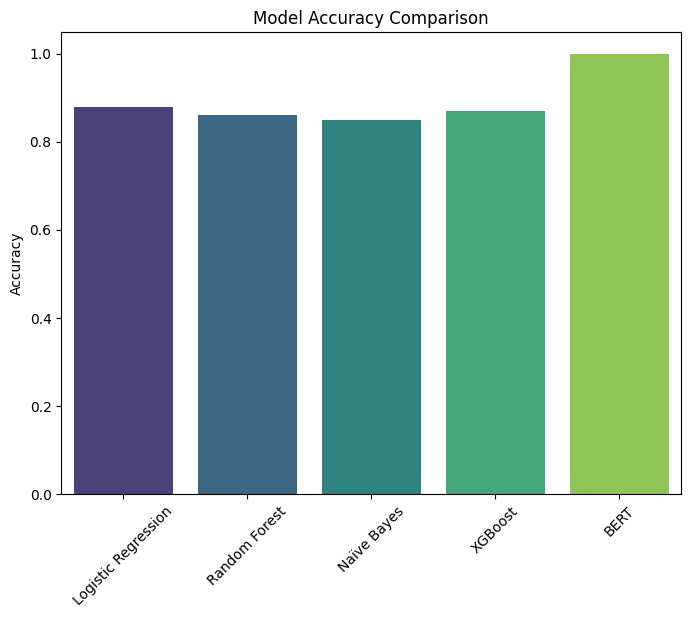

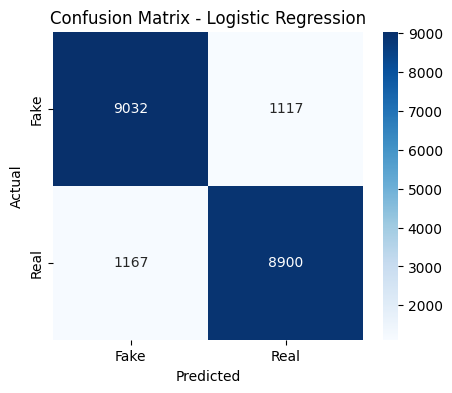

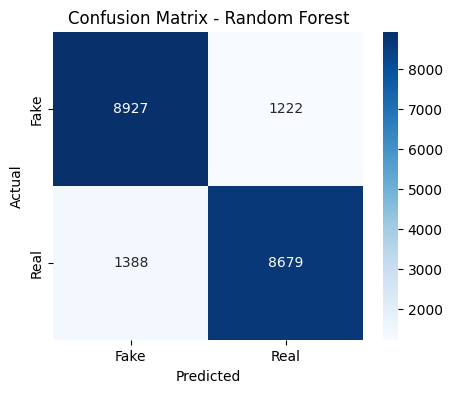

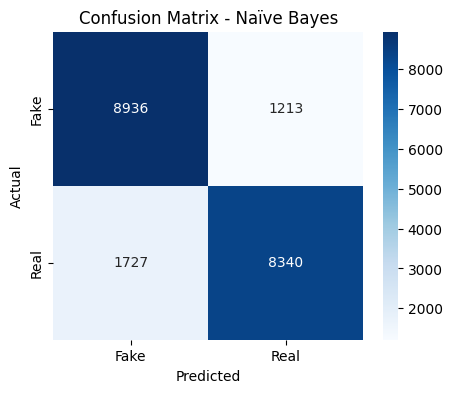

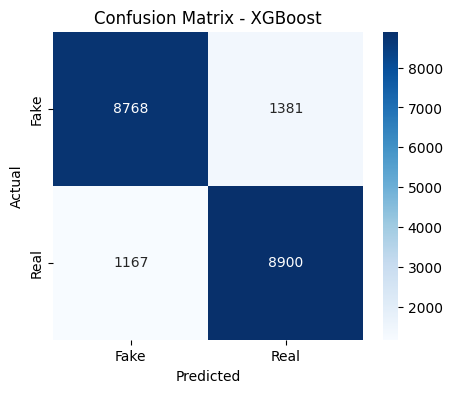

In [15]:
### 9️⃣ Model Performance Visualization
# Bar chart for accuracy comparison
plt.figure(figsize=(8,6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette='viridis')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)
plt.show()

# Confusion matrices
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [18]:
# Save the trained model
torch.save(model.state_dict(), "bert_fake_review_model.pth")
print("✅ Model saved as 'bert_fake_review_model.pth'")


✅ Model saved as 'bert_fake_review_model.pth'


In [19]:
# ----------------- Load and Clean Unlabeled Data -----------------
unlabeled_df = pd.read_csv("/content/Unlabeled_dataset.csv")  # Change path
unlabeled_df['cleaned_text'] = unlabeled_df['review'].apply(clean_text)
texts_to_predict = unlabeled_df['cleaned_text'].tolist()

# ----------------- Prepare Dataset -----------------
class PredictionDataset(Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings['input_ids'])

predict_dataset = PredictionDataset(texts_to_predict)
predict_loader = DataLoader(predict_dataset, batch_size=16)

# ----------------- Load Trained Model -----------------
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.load_state_dict(torch.load("bert_fake_review_model.pth", map_location=device))
model.to(device)
model.eval()

# ----------------- Prediction -----------------
predictions = []
with torch.no_grad():
    for batch in predict_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())

unlabeled_df['predicted_label'] = predictions
unlabeled_df['predicted_label'] = unlabeled_df['predicted_label'].map({0: 'Fake', 1: 'Genuine'})

# ----------------- Save Results -----------------
unlabeled_df.to_csv("Predicted_Reviews.csv", index=False)
print("Prediction saved to 'Predicted_Reviews.csv'")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction saved to 'Predicted_Reviews.csv'


In [26]:
test_df = pd.read_csv('/content/mixed_reviews.csv')


In [27]:
print(test_df.columns)


Index(['review_text', 'label'], dtype='object')


<ipython-input-28-3ea5fb1a67d6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=test_df, palette='pastel')


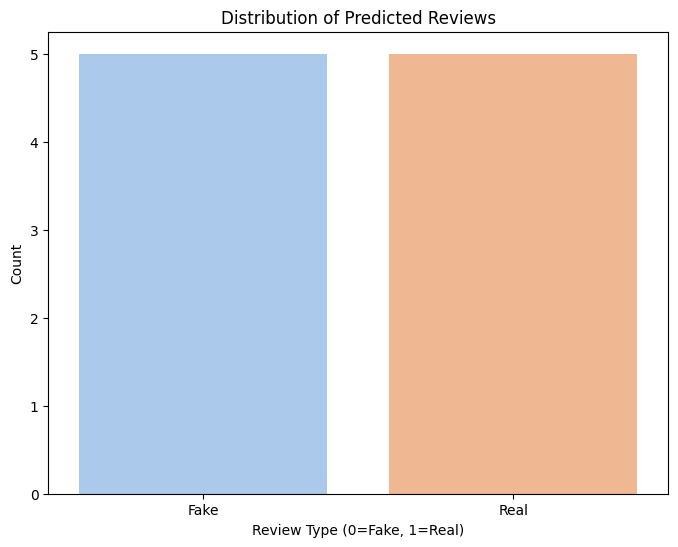

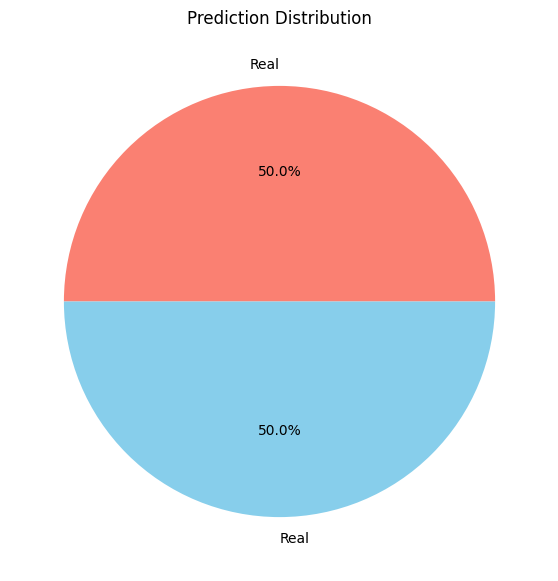

In [28]:
#Predicting on unlabeled dataset
plt.figure(figsize=(8,6))
sns.countplot(x='label', data=test_df, palette='pastel')
plt.title('Distribution of Predicted Reviews')
plt.xlabel('Review Type (0=Fake, 1=Real)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Fake', 'Real'])
plt.show()

# Pie chart to visualize the distribution of predictions
plt.figure(figsize=(7,7))
prediction_counts = test_df['label'].value_counts()

# Dynamically set the labels based on the unique values in prediction_counts
labels = ['Fake' if label == 0 else 'Real' for label in prediction_counts.index]

plt.pie(prediction_counts, labels=labels, autopct='%1.1f%%', colors=['salmon', 'skyblue'])
plt.title('Prediction Distribution')
plt.show()

In [25]:
print(test_df['predicted_label'].unique())


['Genuine']
